# Tutorial 4 - Advanced techniques in error estimation

## Introduction

In this notebook, we investigate the impact of sample correlation on the error estimate of free energy profiles in ThermoLIB. To this end, we will discuss the ussage of the ``decorrelate`` routine and its under-the-hood ``corrtime_from_acf`` routine, including various interesting optional features. Furthermore, we consider various alternative ways (such as block averaging and bootstriding) of constructing free energy profiles to attempt to estimating error bars and compare the results at the end.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from thermolib.thermodynamics.fep import SimpleFreeEnergyProfile, plot_profiles
from thermolib.thermodynamics.histogram import Histogram1D, plot_histograms
from thermolib.tools import read_wham_input, blav, decorrelate, corrtime_from_acf
from thermolib.thermodynamics.trajectory import ColVarReader
from thermolib.units import *

import numpy as np, matplotlib.pyplot as pp

In [3]:
prefix = 'advanced_wham1D_error_'

## Impact correlation between samples on FEP

In this section, we illustrate the impact of correlation between subsequent samples in the MD trajectories. To that end, we apply a regular WHAM procedure to all biased simulation data defined in data/wham_input.txt using all trajectory samples, as well as using only a sample every 10/100/1000 steps.

In [4]:
bins = np.arange(-1.6, 1.6, 0.02)
fn_meta = 'data/formic_acid_dimer/wham_input.txt'

In [5]:
colvar_reader_1 = ColVarReader([0], units=['au'])
temp, biasses, trajectories_1 = read_wham_input(
    fn_meta, colvar_reader_1, 'colvars/correlated/COLVAR_%s.dat', 
    bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
)
hist_1 = Histogram1D.from_wham(bins, trajectories_1, biasses, temp, error_estimate='mle_f', Nscf=10000)
fep_1 = SimpleFreeEnergyProfile.from_histogram(hist_1, temp=temp)

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.180s
  bias poten. : 00h 00m 00.007s
  solve scf   : 00h 00m 00.201s
  error est.  : 00h 00m 00.386s
  TOTAL       : 00h 00m 00.776s
---------------------------------------------------------------------


In [6]:
colvar_reader_10 = ColVarReader([0], stride=10 ,units=['au'])
temp, biasses, trajectories_10 = read_wham_input(
    fn_meta, colvar_reader_10, 'colvars/correlated/COLVAR_%s.dat', 
    bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
)
hist_10 = Histogram1D.from_wham(bins, trajectories_10, biasses, temp, error_estimate='mle_f', Nscf=10000)
fep_10 = SimpleFreeEnergyProfile.from_histogram(hist_10, temp=temp)

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.019s
  bias poten. : 00h 00m 00.008s
  solve scf   : 00h 00m 00.155s
  error est.  : 00h 00m 00.525s
  TOTAL       : 00h 00m 00.709s
---------------------------------------------------------------------


In [7]:
colvar_reader_100 = ColVarReader([0], stride=100 ,units=['au'])
temp, biasses, trajectories_100 = read_wham_input(
    fn_meta, colvar_reader_100, 'colvars/correlated/COLVAR_%s.dat', 
    bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
)
hist_100 = Histogram1D.from_wham(bins, trajectories_100, biasses, temp, error_estimate='mle_f', Nscf=10000)
fep_100 = SimpleFreeEnergyProfile.from_histogram(hist_100, temp=temp)

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.003s
  bias poten. : 00h 00m 00.007s
  solve scf   : 00h 00m 00.413s
  error est.  : 00h 00m 00.421s
  TOTAL       : 00h 00m 00.846s
---------------------------------------------------------------------


In [8]:
colvar_reader_1000 = ColVarReader([0], stride=1000 ,units=['au'])
temp, biasses, trajectories_1000 = read_wham_input(
    fn_meta, colvar_reader_1000, 'colvars/correlated/COLVAR_%s.dat', 
    bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
)
hist_1000 = Histogram1D.from_wham(bins, trajectories_1000, biasses, temp, error_estimate='mle_f', Nscf=10000)
fep_1000 = SimpleFreeEnergyProfile.from_histogram(hist_1000, temp=temp)

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.001s
  bias poten. : 00h 00m 00.007s
  solve scf   : 00h 00m 00.508s
  error est.  : 00h 00m 00.917s
  TOTAL       : 00h 00m 01.434s
---------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

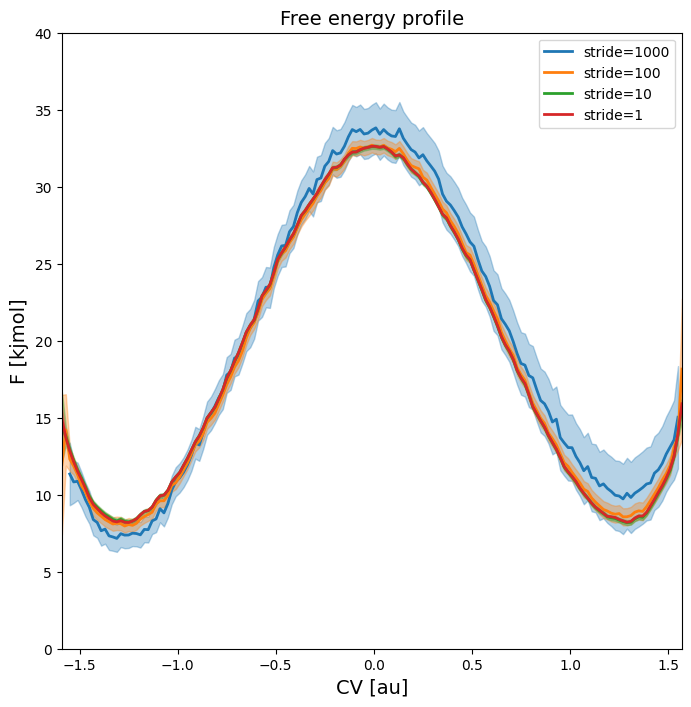

In [9]:
plot_profiles([fep_1000,fep_100,fep_10,fep_1], labels=['stride=1000', 'stride=100', 'stride=10', 'stride=1'], flims=[0,40])

The plot above indicates that the error becomes larger as the stride increases (which is logical as it gives WHAM a lot less data to work with). We also observe that the (mean) estimated free energy itself becomes more noisy as the stride increases, which is also due to lower number of samples.

## Estimating the autocorrelation time

The question now is which is the most reliable representation of the error. To that end, we estimate the correlation time from the autocorrelation function of the collective variable itself during the trajectories. We first illustrate this for a few individual trajectories:

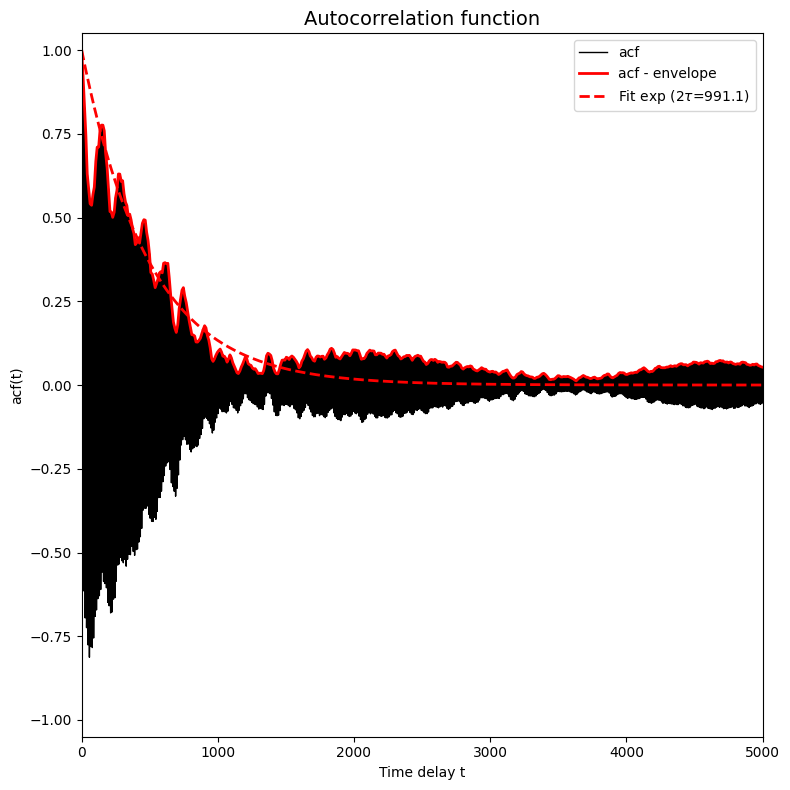

In [10]:
corrtime = corrtime_from_acf(trajectories_1[8], plot=True, xlims=[0,5000], ylims=[-1.05,1.05])

In this plot the black solid line (which became a solid black region because it is a very fast oscilling curve, see further) represents the autocorrelation function, the red solid line represents the envoloppe of the black curve/region and the red dashed curve presents a fit of $\exp(-\frac{t}{\tau})$ to the red solid curve.

The above plot is an example of a typical situation in which the trajectory contains atomistic vibrations that happen on a very small time scale. These vibrations are responsible for the very high frequency oscillations you see in the plot above (resulting in the seemingly solid black region). If we want to fit a simple exponential function (to estimate the time decay constant which is the correlation time), we cannot fit directly to the curve itself as it fluctuates equally between above and below zero and hence any fit will give flat curve. Instead, we first filter out the very high frequency oscillations by computing the enveloppe of the curve. This is done by default in the ``corrtime_from_acf`` routine given the default value ``n_nested_envelopes=1``, but can be switched off by means of setting `n_nested_envelopes=0`. 

In some cases, it is usefull to indeed switch this off. For example when you did a simulation in which you did not print out every time step, but only every so many time steps resulting in a time series that do not contain these high frequency oscillations any more. In other situations it might be the case the enveloppe still contains such oscillations that make fitting difficult, then you can compute the enveloppe of the enveloppe by setting `n_nested_envelopes=2`. Below, we show what happens if we put `n_nested_envelopes=2` for the current case.

/home/lvduyfhu/miniconda3/envs/thermolib/lib/python3.14/site-packages/thermolib/tools.py:967: OptimizeWarning: Covariance of the parameters could not be estimated
  pars, pcovs = curve_fit(function, upper_envelope_indices, upper_envelope_values, **curve_fit_kwargs)


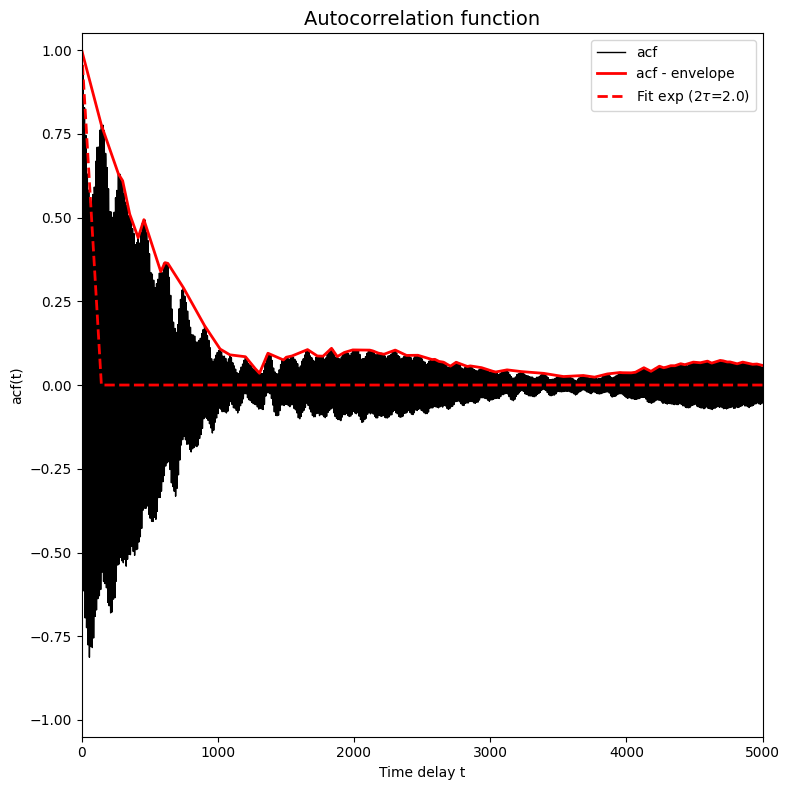

Fitted (integrated) correlation time: 2*tau =  2.000 timesteps


In [11]:
ct = corrtime_from_acf(trajectories_1[8], plot=True, xlims=[0,5000], ylims=[-1.05,1.05], n_nested_envelopes=2)
print('Fitted (integrated) correlation time: 2*tau =  %.3f timesteps' %ct)

You indeed see that the enveloppe contains even less oscillations. However, a new problem arises, a problem that also might have arissen from the start (e.g. again when the simulation only printed out every so many steps). This new issue is that the fit (dashed red line) is very bad. In fact, a closer look to the resulting correlation time reveals that no fit was done at all. Indeed we see that the integrated correlation time equals $2\cdot\tau=2$ or hence $\tau=1$. This is just the initial guess of $\tau$ (which is by default set to 1) is returned. Therefore, we need to adjust the initial gues of the correlation time $\tau$ to a better value, which we can do with the keyword `p0`. If we would make another bad guess, i.e. set the initial gues to 2, we will still be confronted with the same issue. Let us first illustrate that by indeed setting the initial guess to 2:

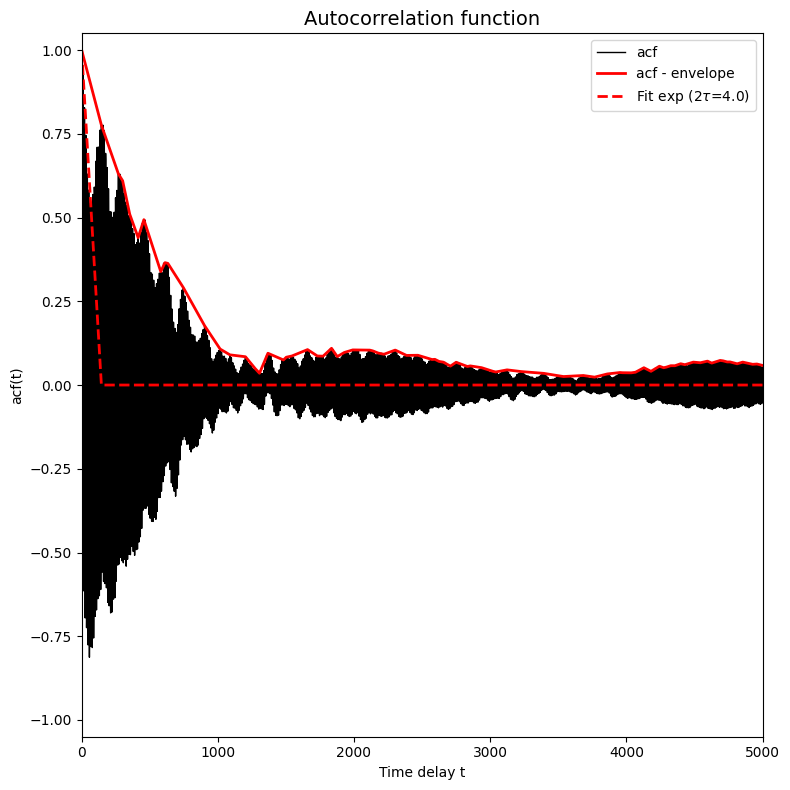

Fitted (integrated) correlation time: 2*tau =  4.000 timesteps


In [12]:
ct = corrtime_from_acf(trajectories_1[8], plot=True, xlims=[0,5000], ylims=[-1.05,1.05], n_nested_envelopes=2, p0=[2])
print('Fitted (integrated) correlation time: 2*tau =  %.3f timesteps' %ct)

We now again clearly see a bad fit, which is also again reflected by the fact that the result $2\cdot\tau=4$ (hence $\tau=2)$ just returns the initial guess. In order to make a better initial gues, we can just look at the plot of the red solid line. We clearly see that the initial decay happens on a time scale of 1000 timesteps, so we could just use that as initial guess:

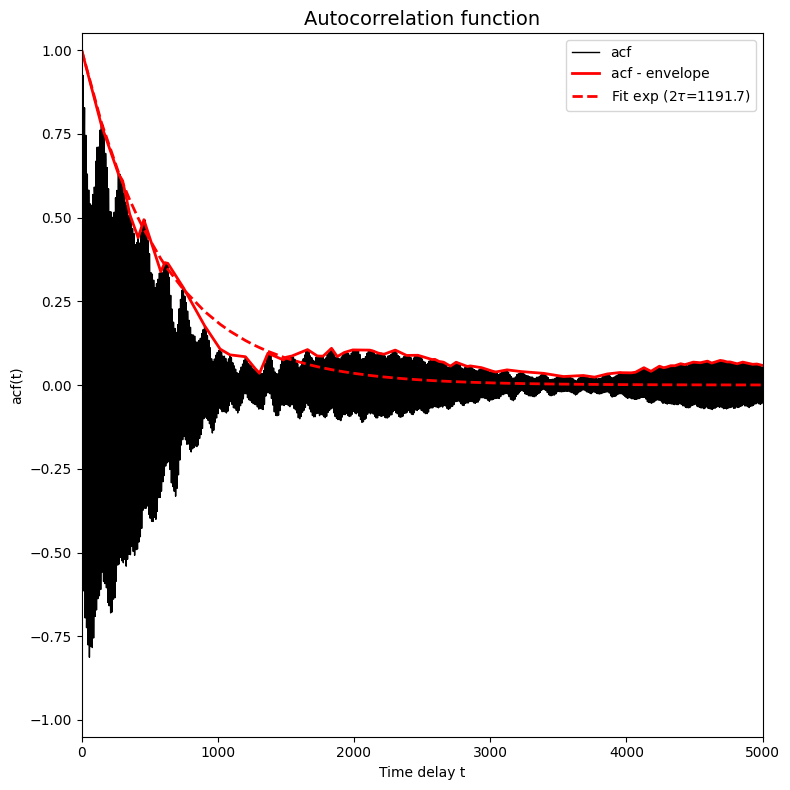

Fitted (integrated) correlation time: 2*tau =  1191.743 timesteps


In [13]:
ct = corrtime_from_acf(trajectories_1[8], plot=True, xlims=[0,5000], ylims=[-1.05,1.05], n_nested_envelopes=2, p0=[1000])
print('Fitted (integrated) correlation time: 2*tau =  %.3f timesteps' %ct)

Which now indeed represents a much better fit. The above discussion is included here to highlight what might happen when computing correlation times and how to try and adress those issues. In the present case, however, the default settings of n_nested_enveloppe=1 and p0=[1] is just fine and we therefore proceed with those default settings.

## Constructing the FEP with correlated error estimate

Let us now compute the correlation time for each trajectory. This can be done using the ``decorrelate`` routine. In this routine, we can also adjust the parameters for the enveloppe and the initial conditions by specifying respectively the ``n_nested_envelopes`` and ``p0`` arguments. However, in the following we can use the default values.

<Figure size 640x480 with 0 Axes>

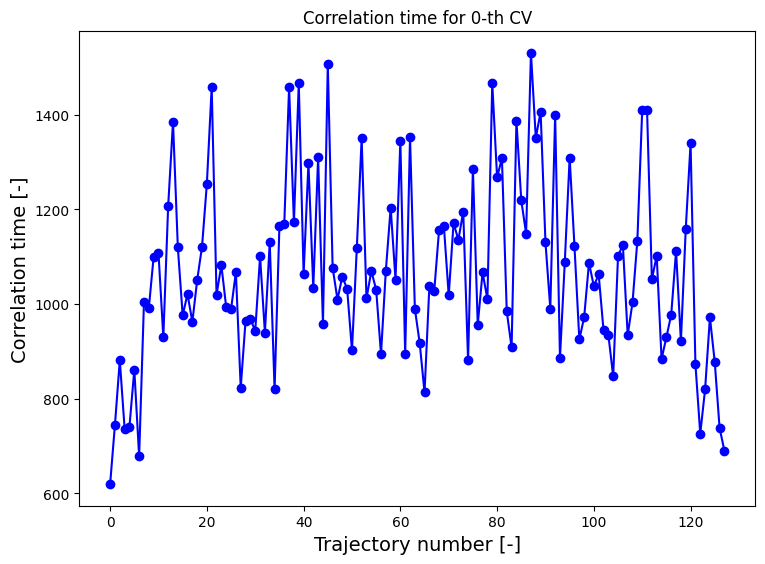

In [14]:
corrtimes = decorrelate(trajectories_1, plot=True)

The above routine returns the correlation times for each simulation (i.e. each umbrella). As the error estimation is based on the Fisher information matrix of the maximum likelihood estimator, we can reconstruct the free energy profile using all original samples, but now we also parse the correlation times to the `from_wham` routine to obtain a more reliable error estimation by accounting for the reduced information due to correlation (i.e. only $\frac{N}{2\cdot\tau-1}$ independent samples instead of $N$) in the information matrix:

In [15]:
hist_decor = Histogram1D.from_wham(bins, trajectories_1, biasses, temp, error_estimate='mle_f', corrtimes=corrtimes, Nscf=10000)
fep_decor = SimpleFreeEnergyProfile.from_histogram(hist_decor, temp=temp)
#fep_decor.set_ref(ref='min')

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.203s
  bias poten. : 00h 00m 00.008s
  solve scf   : 00h 00m 00.214s
  error est.  : 00h 00m 00.181s
  TOTAL       : 00h 00m 00.608s
---------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

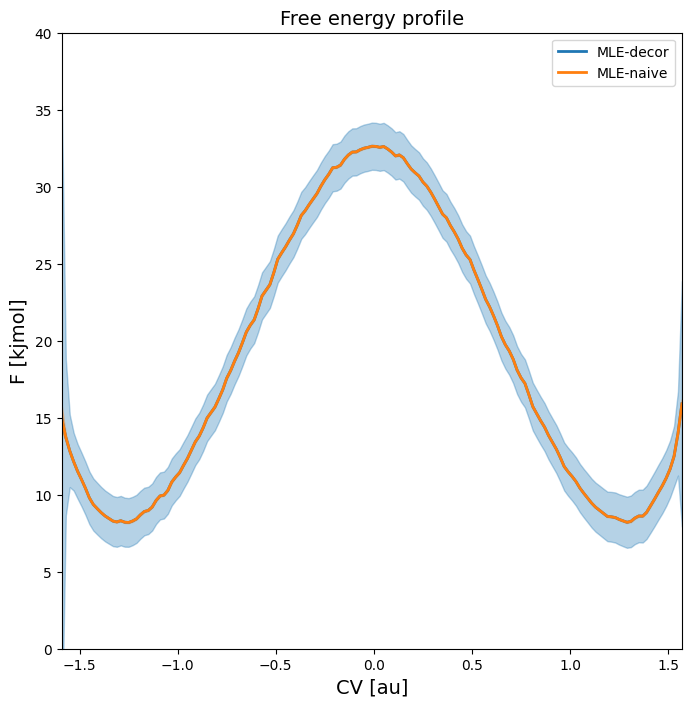

In [16]:
plot_profiles([fep_decor,fep_1], labels=['MLE-decor', 'MLE-naive'], flims=[0,40])

We indeed see that the error bar increases from almost zero (for the case of assuming all samples to be independent, i.e. correlation time equal to 0) to a value of around 1-2 kJ/mol based on the correlation time.

## Evaluating the correlated error estimate

In order to test the above error estimation, we are now going to generate profiles from various sources of subsets of the original trajectories and investigate whether the WHAM profile generated by each subset indeed falls within the predicted error bar. In order to make a fair comparison in terms of the error bar, we will make sure that each method uses trajectories that have approximately a number of samples equal to $\frac{N}{2\cdot\tau-1}\approx\frac{200000}{1000}=200$, i.e. the previously estimated number of uncorrelated samples in a trajectory. The various methods for generating subsets of data are:

1) Delayed-strided profiles: subset starting at sample 0, 100, 200, ... and with with a sampling stride of 1000
2) Blocked profiles: subset [0,200], [200,400], ...
3) Bootstrapped profiles: subsets each containing 200 random samples

### Delayed-strided WHAM profiles

In [17]:
starts = np.arange(0,1000,100)
feps = []
for start in starts:
    print("Constructing WHAM FEP for start=%i" %start)
    colvar_reader = ColVarReader([0], units=['au'], start=start, stride=1000)
    temp, biasses, trajectories = read_wham_input(
        fn_meta, colvar_reader, 'colvars/correlated/COLVAR_%s.dat', 
        bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
    )    
    hist = Histogram1D.from_wham(bins, trajectories, biasses, temp, Nscf=10000)
    fep = SimpleFreeEnergyProfile.from_histogram(hist, temp)
    #fep.set_ref(ref='min')
    feps.append(fep)

Constructing WHAM FEP for start=0
SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.001s
  bias poten. : 00h 00m 00.006s
  solve scf   : 00h 00m 00.532s
  error est.  : 00h 00m 00.000s
  TOTAL       : 00h 00m 00.541s
---------------------------------------------------------------------
Constructing WHAM FEP for start=100
SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.001s
  bias poten. : 00h 00m 00.006s
  solve scf   : 00h 00m 00.482s
  error est.  : 00h 00m 00.000s
  TOTAL       : 00h 00m 00.490s
---------------------------------------------------------------------
Constructing WHAM FEP for start=200
SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.001s
  bias

<Figure size 640x480 with 0 Axes>

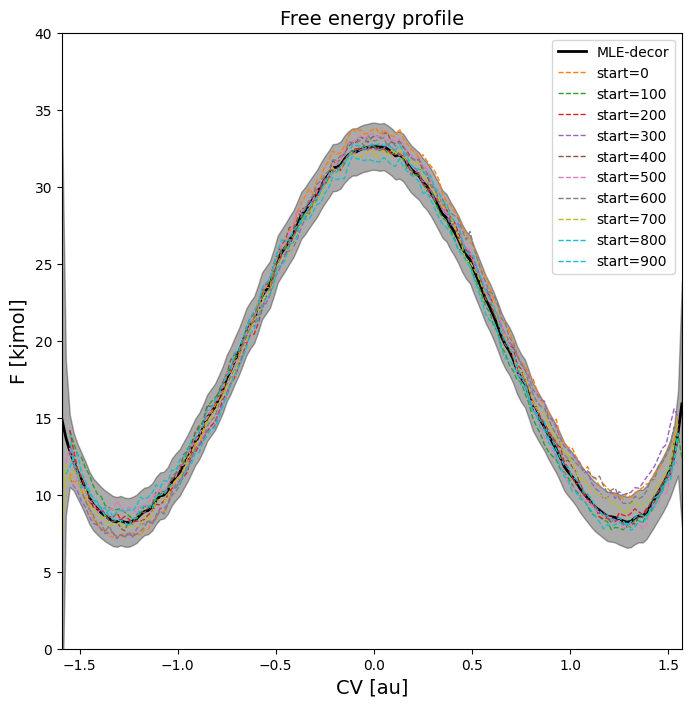

In [18]:
fep_delstr = SimpleFreeEnergyProfile.from_average(feps, error_estimate='std')
plot_profiles([fep_decor]+feps, labels=['MLE-decor']+['start=%i' %start for start in starts], flims=[0,40],
               colors    =['k']+[None,]*len(starts),
               linewidths=[2  ]+[1   ,]*len(starts),
               linestyles=['-']+['--',]*len(starts))

All profiles indeed fall within the predicted 2-sigma error bar.

### Blocked WHAM profile

Here, for each original trajectory, a new trajectory is constructed in which each subsequent block of 1000 samples is replaced by its average.

In [19]:
blocksize = 1000
nblocks = int(min([len(traj) for traj in trajectories_1])/blocksize)
new_trajs = []
for itraj, trajectory in enumerate(trajectories_1):
    new_traj = np.zeros(nblocks)
    for i in range(nblocks):
        new_traj[i] = trajectory[i*blocksize:(i+1)*blocksize].mean()
    new_trajs.append(new_traj)
hist_block = Histogram1D.from_wham(bins, new_trajs, biasses, temp)
fep_block = SimpleFreeEnergyProfile.from_histogram(hist_block, temp)

SCF did not converge!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.015s
  bias poten. : 00h 00m 00.090s
  solve scf   : 00h 00m 00.299s
  error est.  : 00h 00m 00.000s
  TOTAL       : 00h 00m 00.405s
---------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

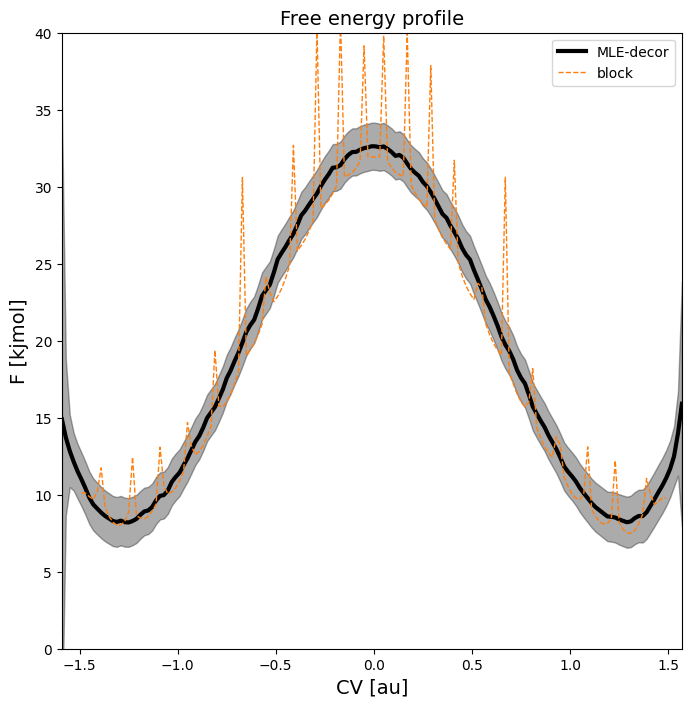

In [20]:
plot_profiles([fep_decor,fep_block], labels=['MLE-decor','block'], flims=[0,40], 
                colors=['k',None], linestyles=['-','--'], linewidths=[3,1])

We see that the block profile is within the error predicted by the decorrelated profile, except for the many spikes. These spikes are due to the severaly overlap between subsequant umbrella trajectories after averaging. To illustrate lets consider the histograms of 3 subsequent original trajectories as well their blocked counterparts:

<Figure size 640x480 with 0 Axes>

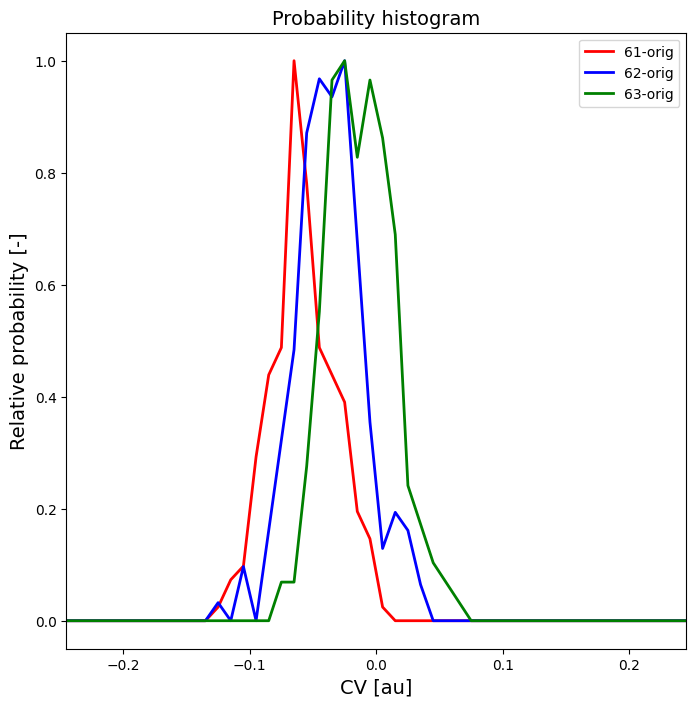

In [21]:
bins2 = np.arange(-0.25,0.251,0.01)
hists = [
    Histogram1D.from_single_trajectory(trajectories[61],bins2), 
    Histogram1D.from_single_trajectory(trajectories[62],bins2), 
    Histogram1D.from_single_trajectory(trajectories[63],bins2), 
    ]
labels = ['61-orig', '62-orig', '63-orig', ]
plot_histograms(hists, labels=labels, linestyles=['-','-','-'], colors=['r','b','g'])

The above plot clearly shows sufficient overlap in the original trajectories.

<Figure size 640x480 with 0 Axes>

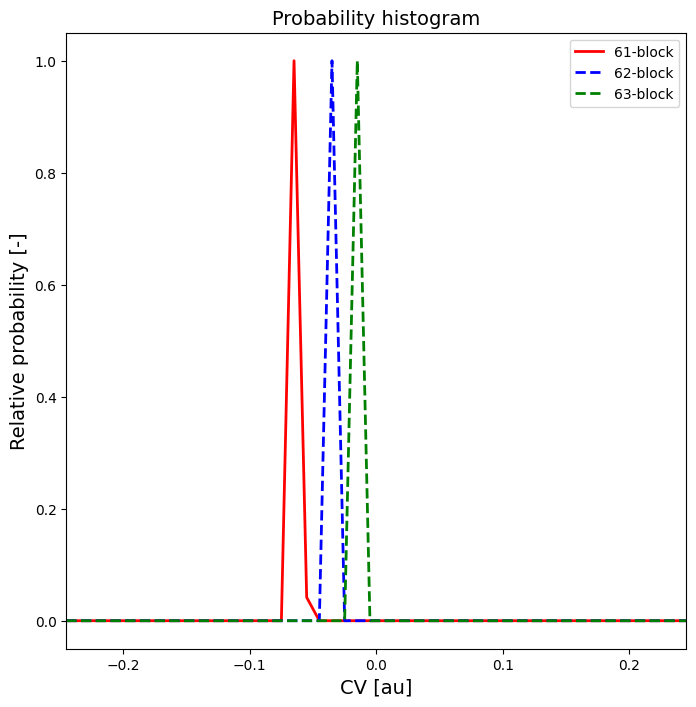

In [22]:
hists = [
    Histogram1D.from_single_trajectory(new_trajs[61],bins2),
    Histogram1D.from_single_trajectory(new_trajs[62],bins2),
    Histogram1D.from_single_trajectory(new_trajs[63],bins2),
    ]
labels = ['61-block', '62-block', '63-block']
plot_histograms(hists, labels=labels, linestyles=['-','--','--'], colors=['r','b','g'])

The above plot clearly shows a lack of overlap in the new trajectories.

### Bootstrapped WHAM profiles

Finally, we again reconstruct various FEPS, but know using bootstrapping applied to each of the original biased simulations. Again, we consider 10 trajectories.

In [23]:
Nboot = 10
size = 200
feps3 = []
for iboot in range(Nboot):
    new_trajectories = []
    for traj in trajectories_1:
        Nsteps = len(traj)
        indices = np.random.randint(0, high=Nsteps, size=size)
        new_trajectories.append(traj[indices]) 
    hist = Histogram1D.from_wham(bins, new_trajectories, biasses, temp, Nscf=10000)
    fep = SimpleFreeEnergyProfile.from_histogram(hist, temp)
    feps3.append(fep)

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.027s
  bias poten. : 00h 00m 00.072s
  solve scf   : 00h 00m 02.358s
  error est.  : 00h 00m 00.000s
  TOTAL       : 00h 00m 02.458s
---------------------------------------------------------------------
SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.010s
  bias poten. : 00h 00m 00.032s
  solve scf   : 00h 00m 01.498s
  error est.  : 00h 00m 00.000s
  TOTAL       : 00h 00m 01.542s
---------------------------------------------------------------------
SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.006s
  bias poten. : 00h 00m 00.031s
  solve scf   : 00h 00m 01.691s
  error est.  : 00h 00m 00.000s
  TOTAL       : 

<Figure size 640x480 with 0 Axes>

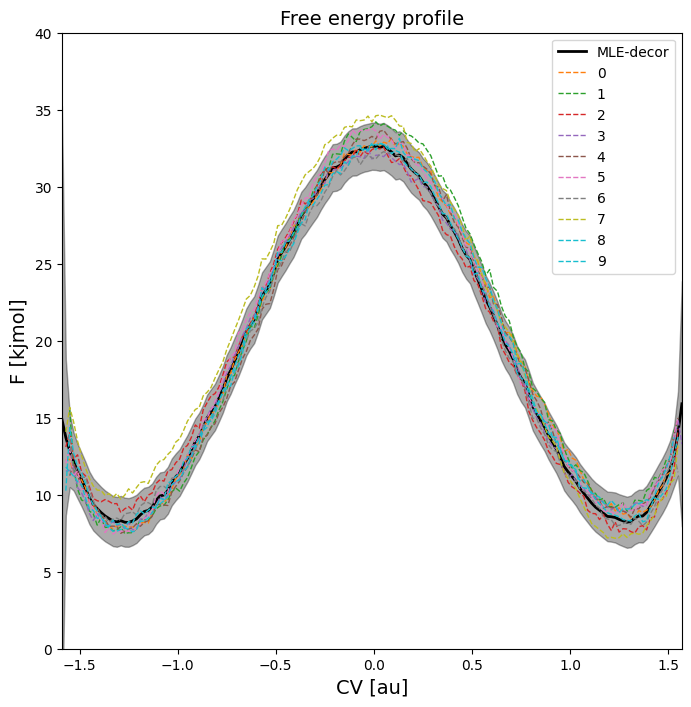

In [24]:
fep_boot = SimpleFreeEnergyProfile.from_average(feps3, error_estimate='std')
plot_profiles([fep_decor]+feps3, labels=['MLE-decor']+['%i' %i for i in np.arange(0,10,1)], flims=[0,40],
               colors    =['k']+[None,]*10,
               linewidths=[2  ]+[1   ,]*10,
               linestyles=['-']+['--',]*10)

We clearly see that all free energy profiles from the bootstrapped subtrajectories all fall well within the error bar computed by the MLE procedure using the decorrelated data.

## Covariance between different points on FEP

It is important to realize that the free energy at $q_1$ is not independent from the free energy at $q_2$, in other words that the covariance between these points is not negligible. This is not only the case for close neighbors (large positive correlation), but in the present case of a profile with two equistable minima, also between points from these equistable minima (i.e. reactant and product state). The main reason for this the fact that the free energy is derived from a normalized probability and this normalization introduces a strong negative correlation between these two equistable minima, because decreased free energy (i.e. increased probability) for reactant implies increased free energy (i.e. decreased probality) for product. 

To illustrate the importance of this, we first plot samples of the full free energy profile according to error bars without covariance (using `error_estimate=mle_f`) and show the difference with the scenario where we redo the error estimation with explicit covariance using `error_estimate=mle_f_cov`.

Considering first the free energy profile without covariance, we can plot samples using the plot routine as follows:

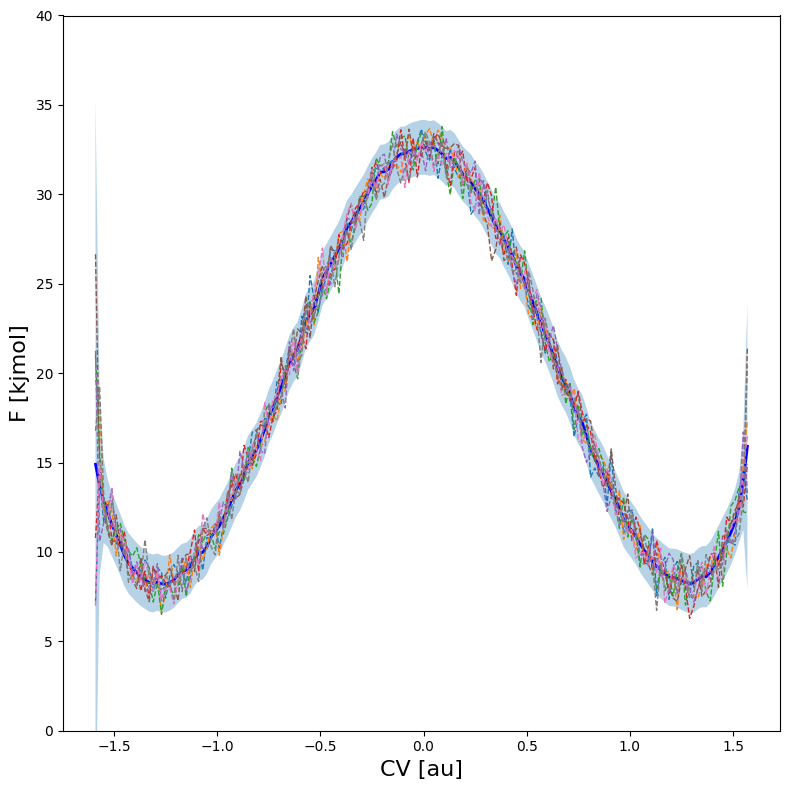

In [25]:
fep_decor.plot(
    obss      = ['mean']+['sample',]*8,
    linestyles=    ['-']+    ['--',]*8,
    linewidths=      [2]+       [1,]*8,
    colors    =    ['b']+    [None,]*8,
    flims=[0,40]
)

As we can see, the error just corresponds to normally random fluctuations on all points individually without any correlation between fluctuations.

We now reconstruct the error on the fep by explicitly taking the covariance into account.

In [26]:
hist_cov = Histogram1D.from_wham(bins, trajectories_1, biasses, temp, error_estimate='mle_f_cov', corrtimes=corrtimes, Nscf=10000)
fep_cov = SimpleFreeEnergyProfile.from_histogram(hist_cov, temp, cv_output_unit='au', cv_label='CV', f_output_unit='kjmol')
fep_cov.process_states(lims=[-1.5,-0.2,0.2,1.5])

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 01.048s
  bias poten. : 00h 00m 00.056s
  solve scf   : 00h 00m 01.465s
  error est.  : 00h 00m 02.440s
  TOTAL       : 00h 00m 05.010s
---------------------------------------------------------------------


As can be seen in the free energy profile below, the 2-sigma error bar on the entire profile is identical with or without accounting for covariance:

<Figure size 640x480 with 0 Axes>

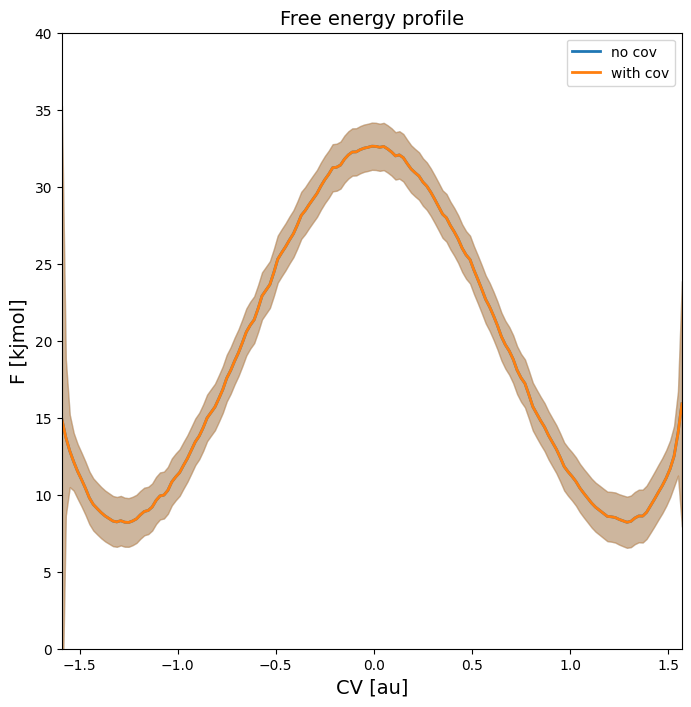

In [27]:
plot_profiles([fep_decor,fep_cov], labels=['no cov', 'with cov'], flims=[0,40])

However, the coviarance is clearly non neglible as seen in the matrix plot below of the correlation matrix between the various points on the fep. This correlation ranges from 1 (perfect correlation), to 0 (completely uncorrelated) and -1 (perfect anticorrelation).

<Figure size 640x480 with 0 Axes>

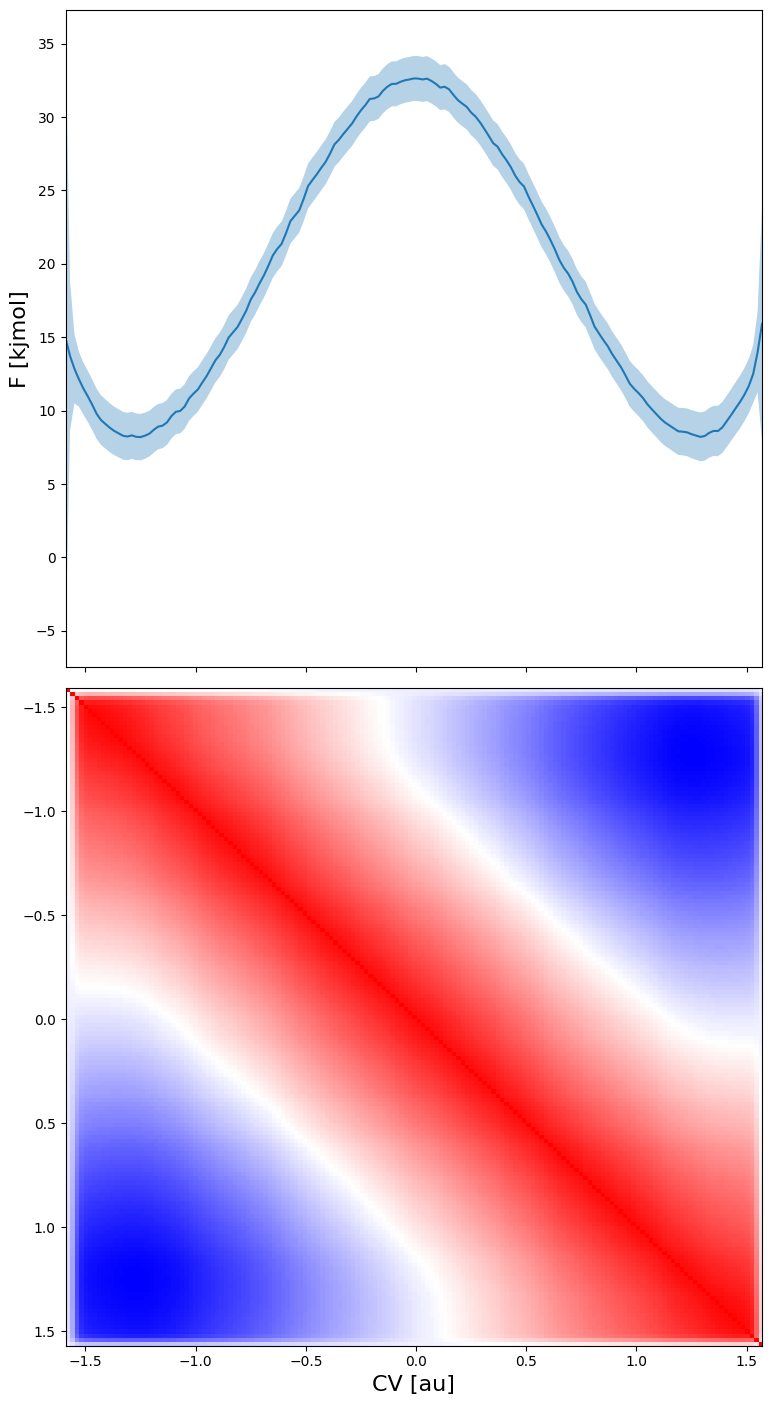

In [28]:
fep_cov.plot_corr_matrix()

Therefore, the error model in fep_cov generates much more reliable 'samples' of the full free energy profile by taking into account the full covariance matrix. This can again be plotted using the `fep_cov.plot_samples` routine:

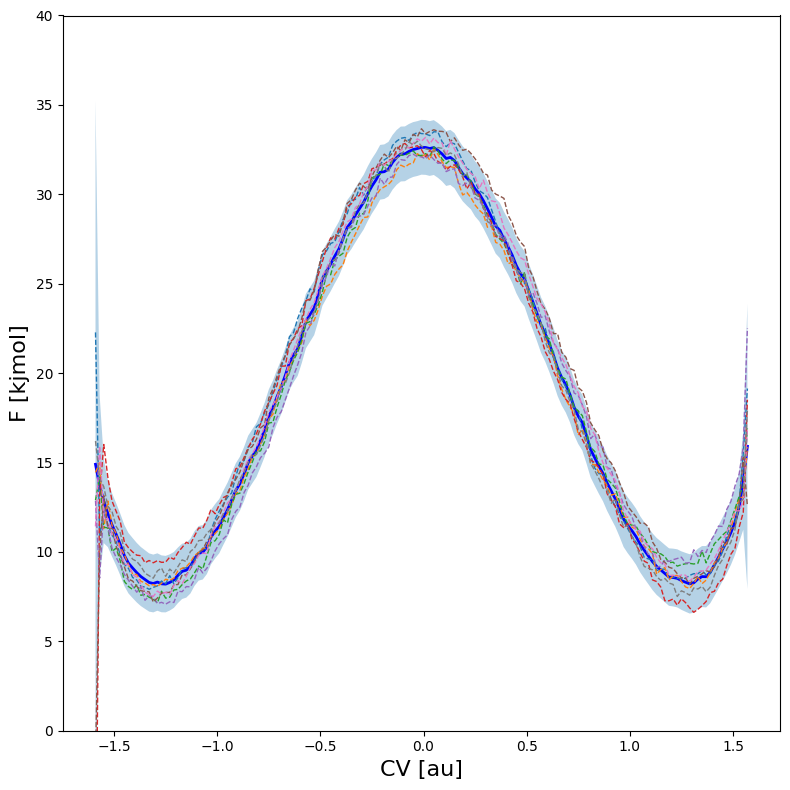

In [29]:
fep_cov.plot(
    obss      = ['mean']+['sample',]*8,
    linestyles=    ['-']+    ['--',]*8,
    linewidths=      [2]+       [1,]*8,
    colors    =    ['b']+    [None,]*8,
    flims=[0,40]
)

This figure clearly illustrates that higher free energy for reactant state also implies lower free energy for the product state and vice versa!

## Error propagation

Such correlated estimates of samples of the full free energy profile allows to do proper error propagation, i.e. to compute the free energy of integrated macrostates. To illustrate that, we compute propagate the error on the profile to that on the microstate/macrostate free energy derived from the profile for both the fep without covariance (i.e. fep_decor) and that with covariance estimate (i.e. fep_cov):

In [30]:
fep_decor.process_states(lims=[-1.5,-0.5,0.5,1.5], verbose=True)

MICROSTATE ts:
--------------
  index =  None
  F     = 33.776 +- 0.806 kjmol
  CV    = 0.014 +- 0.148 au

MICROSTATE r:
--------------
  index =  None
  F     = 7.100 +- 0.998 kjmol
  CV    = -1.292 +- 0.131 au

MICROSTATE p:
--------------
  index =  None
  F     = 7.068 +- 0.848 kjmol
  CV    = 1.286 +- 0.120 au

MACROSTATE R:
--------------
  F       = 10.337 +- 0.307 kjmol
  CV Mean = -1.236 +- 0.015 au
  CV StD  = 0.145 +- 0.009 au

MACROSTATE P:
--------------
  F       = 10.439 +- 0.317 kjmol
  CV Mean = 1.232 +- 0.016 au
  CV StD  = 0.146 +- 0.009 au



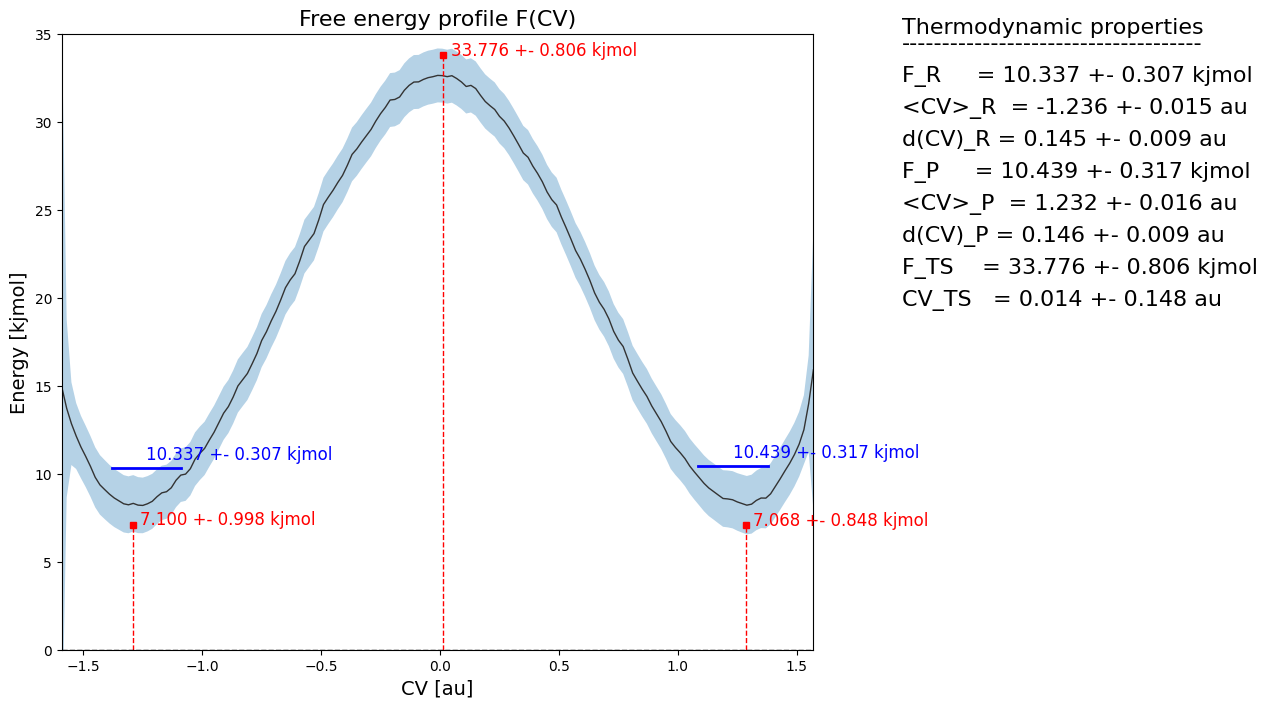

In [31]:
fep_decor.plot(flims=[0,35])

Here, we clearly see that estimate of the red microstate dots representing local minima (reactant ant product) and maxima (transition state) are located on the lower/upper edge of the error bar respectively. That is because in the random samples of the full fep, the lack of correlation between neighboring points (which results in uncorrelated fluctuation on the free energy of each point) ensures that there will always be a point close to the lower/upper error bar boundary. Furthermore, we also see a much lower error on the blue macrostates representing the integral over reactant (left of ts) and product (right of ts) microstates. This is because the random fluctuation resulting the uncorrelated error bar is moslty filtered out by the integral.

This clearly indicates the failure of uncorrelated error bars for propagation towards derived properties. Instead, we need to do such error propagation using correlated error bars coming from accounting for the full covariance matrix.

In [32]:
fep_cov.process_states(lims=[-1.5,-0.5,0.5,1.5], verbose=True)

MICROSTATE ts:
--------------
  index =  None
  F     = 32.964 +- 1.356 kjmol
  CV    = 0.005 +- 0.110 au

MICROSTATE r:
--------------
  index =  None
  F     = 8.102 +- 1.455 kjmol
  CV    = -1.280 +- 0.079 au

MICROSTATE p:
--------------
  index =  None
  F     = 7.907 +- 1.524 kjmol
  CV    = 1.288 +- 0.067 au

MACROSTATE R:
--------------
  F       = 10.747 +- 1.572 kjmol
  CV Mean = -1.235 +- 0.022 au
  CV StD  = 0.147 +- 0.010 au

MACROSTATE P:
--------------
  F       = 10.481 +- 1.224 kjmol
  CV Mean = 1.231 +- 0.030 au
  CV StD  = 0.146 +- 0.010 au



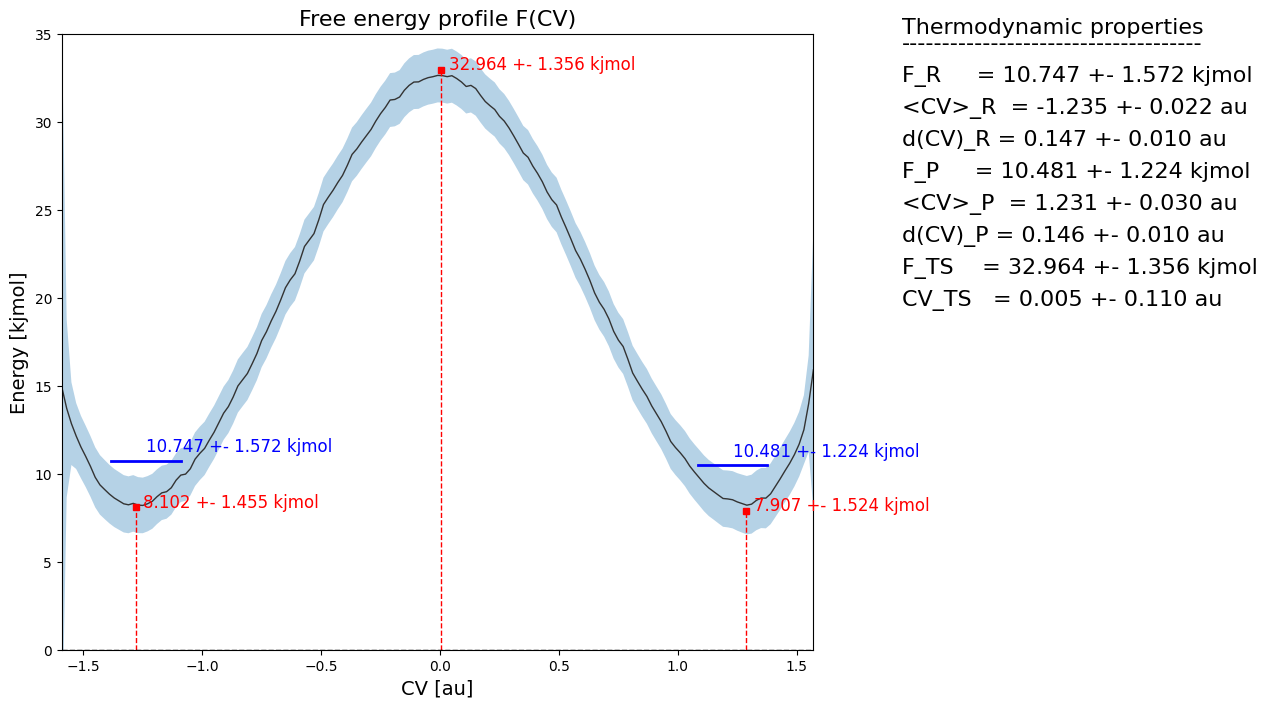

In [33]:
fep_cov.plot(flims=[0,35])